In [9]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from astropy import cosmology
import matplotlib.pyplot as plt
import getdist as gd
from getdist import MCSamples
import getdist.plots as gdplot
import matplotlib
from scipy.stats import norm
import matplotlib.mlab as mlab
from autogalaxy.util import cosmology_util
from astropy import constants

cosmo = cosmology.Planck15

In [10]:
from autoconf import conf
import autofit as af
import autolens as al
import autolens.plot as aplt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from matplotlib import gridspec as gridspec
from matplotlib.colors import SymLogNorm
import re
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from autoarray.structures import grids
from autoarray.structures import vector_fields

fig_path = '/Users/dgmt59/Documents/Plots/weak_lensing/'

In [11]:
workspace_path = "/Users/dgmt59/PycharmProjects/autolens_slacs/"
output_path = "/Users/dgmt59/output"
aggregator_results_path_1 = output_path + "/slacs_shu_bspline_clean/"
weak_data_path = "/Users/dgmt59/Documents/Data/slacs_weak_lensing/"
header_path = "/Users/dgmt59/Documents/Data/SLACS_headers/"
slacs_shu_path = "/Users/dgmt59/PycharmProjects/autolens_slacs_pre_v_1/dataset/slacs_shu/"

In [12]:
agg = af.Aggregator(directory=str(aggregator_results_path_1), completed_only=True)

Aggregator loading phases... could take some time.

 A total of 330 phases and results were found.


In [13]:
phase_name = "phase[4]_mass[total]_source[fixed]/settings"

agg_shear_sie = agg.filter(agg.directory.contains(phase_name))

print("Total Outputs = ",len(agg_shear_sie))

Filter found a total of 34 results
Total Outputs =  34


In [14]:
datasets_shear = agg_shear_sie.values("dataset")
outputs_shear = agg_shear_sie.values("samples")
instances_shear = [samps.median_pdf_instance for samps in agg_shear_sie.values("samples")]
lens_no = [re.sub('slacs', '', dataset.name) for dataset in datasets_shear]
ra_lens = [info["RA"] for info in agg_shear_sie.values("info")]
dec_lens = [info["DEC"] for info in agg_shear_sie.values("info")]
ra_dec = [ra[0:2]+' '+ra[2:4]+' '+ra[4:9]+' '+dec[0:3]+' '+dec[3:5]+' '+dec[5:9] for ra, dec in zip(ra_lens, dec_lens)]

In [15]:
centres_arcsec = []
centres_pix = []

for lens in lens_no:
    centre_arcsec = open(f"{slacs_shu_path}slacs{lens}/lens_centre_arc_sec.dat").read()
    centre_pix = open(f"{slacs_shu_path}slacs{lens}/lens_centre_pix.dat").read()
    y_arc, x_arc = centre_arcsec[2:-3].split(',')
    y_pix, x_pix = centre_pix[2:-3].split(',')
    centres_arcsec.append([float(y_arc), float(x_arc)])
    centres_pix.append([float(y_pix), float(x_pix)])



In [16]:
def move_origin_in_arcsec_to(centre, x, y):
    new_x = []
    new_y = []
    for i in range(len(x)):
        new_x.append(x[i]-centre[1])
        new_y.append(y[i]-centre[0])

    return np.transpose(np.array([new_y, new_x]))

In [20]:
radii = np.arange(12, 46, 1)#in arcseconds
pixel_scale=0.03

for lens, centre_p, centre_a, instance in zip(lens_no, centres_pix, centres_arcsec, instances_shear):
    shears = []
    angles = []

    weak_shear_data = fits.open(f"{weak_data_path}{lens}_F814W_drz_sci_clean.shears")
    data = weak_shear_data[1].data
    field_image_data  = get_pkg_data_filename(f"{weak_data_path}{lens}_F814W_drz_sci.fits")
    image = fits.open(field_image_data)[0]
    wcs = WCS(image.header)

    R_Ein = instance.galaxies.lens.mass.einstein_radius
    centre_x = instance.galaxies.lens.mass.centre[1]
    centre_y = instance.galaxies.lens.mass.centre[0]
    axis_ratio = instance.galaxies.lens.mass.axis_ratio
    phi = instance.galaxies.lens.mass.phi-90-image.header["ORIENTAT"]

    sie = al.mp.EllipticalIsothermal(
            centre=(centre_y, centre_x),
            einstein_radius=R_Ein,
            elliptical_comps=al.convert.elliptical_comps_from(
                axis_ratio=axis_ratio,
                phi=phi))

    arcs_sec_x, arc_sec_y = data.x *pixel_scale, data.y*pixel_scale
    centre_arc_sec = pixel_scale*np.asarray(centre_p)
    arc_sec_centred = move_origin_in_arcsec_to(centre=centre_arc_sec, x=arcs_sec_x, y=arc_sec_y)

    weak_shear_grid = grids.GridIrregular(
        grid=arc_sec_centred
    )
    weak_shear_field = vector_fields.VectorFieldIrregular(
        grid=weak_shear_grid,
        vectors=np.transpose(np.asarray([data.gamma2, data.gamma1]))
    )

    sie_shear = sie.shear_from_grid(grid=weak_shear_grid)
    weak_shear_sie_sub = weak_shear_field-sie_shear

    for radius in radii:

        weak_shear_sie_sub_inside = weak_shear_sie_sub.vectors_within_radius(centre=(0,0), radius=radius)
        shears.append(weak_shear_sie_sub_inside.average_magnitude)
        angles.append(weak_shear_sie_sub_inside.average_phi)

    fig = plt.figure()
    plt.scatter(radii, shears, color='cyan', marker='x')
    plt.xlabel("radius(arcseconds)")
    plt.ylabel("shear magnitude")
    plt.title(f"slacs{lens}")
    plt.savefig(fig_path + f"radius_v_mag_{lens}.png", bbox_inches='tight', dpi=300)
    plt.close()

    fig2 = plt.figure()
    plt.scatter(radii, angles, color='cyan', marker='x')
    plt.xlabel("radius(arcseconds)")
    plt.ylabel("shear phi")
    plt.title(f"slacs{lens}")
    plt.savefig(fig_path + f"radius_v_angle_{lens}.png", bbox_inches='tight', dpi=300)
    plt.close()

VectorFieldException: The input radius removed all vectors / points on the grid.

In [12]:
def weighted_mean_and_standard_deviation(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- Numpy ndarrays with the same shape.
    """
    values = np.asarray(values)
    weights = np.asarray(weights)
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average) ** 2, weights=weights)
    return (average, np.sqrt(variance))

def magnitude_error_from_agg_obj(agg_obj):

    samples = agg_obj.samples

    magnitudes = []

    for sample_index in range(samples.total_accepted_samples):

        instance = samples.instance_from_sample_index(sample_index=sample_index)

        magnitude = instance.galaxies.lens.shear.magnitude

        magnitudes.append(magnitude)

    return weighted_mean_and_standard_deviation(
        values=magnitudes, weights=samples.weights
    )

def phi_error_from_agg_obj(agg_obj):

    samples = agg_obj.samples

    phis = []

    for sample_index in range(samples.total_accepted_samples):

        instance = samples.instance_from_sample_index(sample_index=sample_index)

        phi = instance.galaxies.lens.shear.phi

        phis.append(phi)

    return weighted_mean_and_standard_deviation(
        values=phis, weights=samples.weights
    )

In [13]:
magnitudes = np.asarray(list(agg_shear_sie.map(func=magnitude_error_from_agg_obj)))
phis = np.asarray(list(agg_shear_sie.map(func=phi_error_from_agg_obj)))

In [22]:
##loading orientat and pa_v3 values from headers
pa_v3 = []
pa_orientat = []
for lens in lens_no:
    strong_header = fits.open(f"{header_path}SLACSJ{lens}_F814W_4_biz.fits")[0]
    field_image_data  = get_pkg_data_filename(f"{weak_data_path}{lens}_F814W_drz_sci.fits")
    image = fits.open(field_image_data)[0]
    pa_v3.append(strong_header.header["PA_V3"])
    pa_orientat.append(image.header["ORIENTAT"])

In [1]:
pa_north_up = [instance.galaxies.lens.shear.phi-90 for instance in instances_shear]
pa_y_up = [instance.galaxies.lens.shear.phi-90+pa for instance, pa in zip(instances_shear, pa_orientat)]

print(pa_y_up)
##putting on 0-180 to compare
pa_y_up = [pa+180 if pa<0 else pa for pa in pa_y_up]
pa_north_up = [pa+360 if pa<-180 else pa+180 if -180<pa<0 else pa for pa in pa_north_up]
average_angle = [pa+180 if pa<0 else pa for pa in average_angle]
average_angle_north_up = [pa+180 if pa<0 else pa for pa in average_angle]



NameError: name 'instances_shear' is not defined

In [31]:
gamma_combined = [gamma*np.cos(2*(phi_sl-phi_wl)*np.pi/180) for gamma, phi_sl, phi_wl in zip(average_shear, pa_y_up, average_angle)]
gamma_combined_north_up = [gamma*np.cos(2*(phi_sl-phi_wl)*np.pi/180) for gamma, phi_sl, phi_wl in zip(average_shear_north_up, pa_north_up, average_angle_north_up)]
gamma_combined_sie_sub = [gamma*np.cos(2*(phi_sl-phi_wl)*np.pi/180) for gamma, phi_sl, phi_wl in zip(average_sie_subtracted_shear, pa_y_up, average_sie_subtracted_angle)]

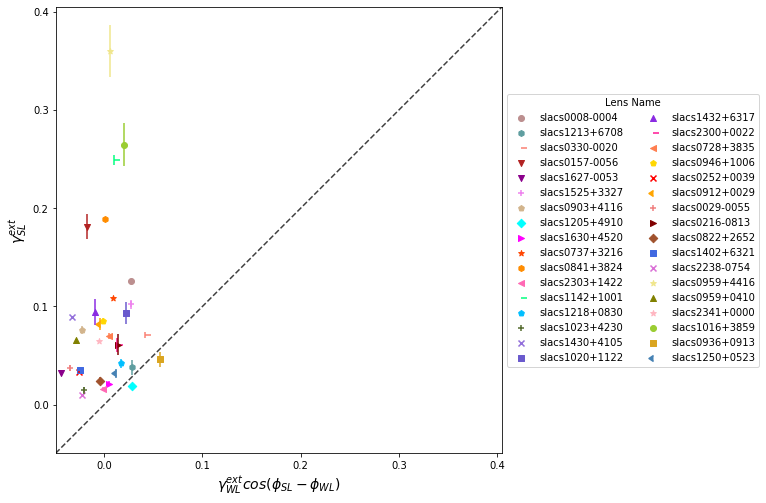

In [32]:
fig1, ax = plt.subplots(figsize=(10,10))
for weak_shear, info, instance, dataset, err in zip(gamma_combined, agg_shear_sie.values("info"), instances_shear, agg_shear_sie.values("dataset"), magnitudes[:, 1]):
    ax.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'], label=dataset.name)
    ax.errorbar(weak_shear, instance.galaxies.lens.shear.magnitude,
                    yerr=err,
                    color=info['colour'])
plt.xlabel(r'$\gamma_{WL}^{ext}cos(\phi_{SL}-\phi_{WL})$', size=14)
plt.ylabel(r'$\gamma_{SL}^{ext}$', size=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
     ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(f"{fig_path}shear_comparison_y_up_combined.png", bbox_inches='tight', dpi=300)

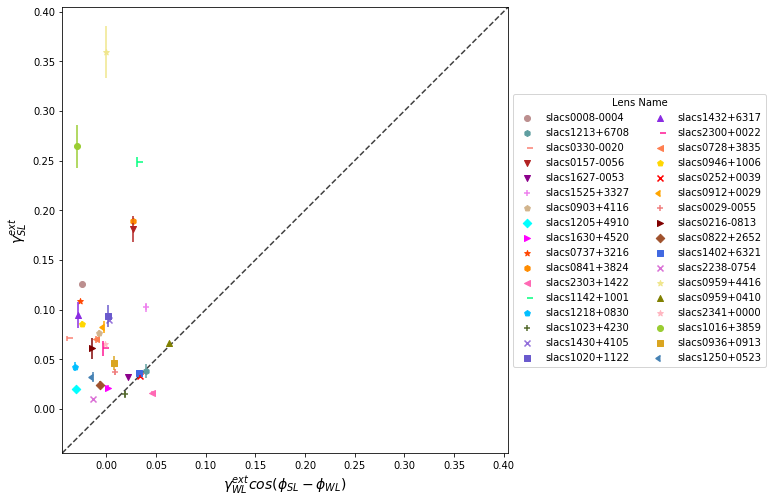

In [33]:
fig1, ax = plt.subplots(figsize=(10,10))
for weak_shear, info, instance, dataset, err in zip(gamma_combined_north_up, agg_shear_sie.values("info"), instances_shear, agg_shear_sie.values("dataset"), magnitudes[:, 1]):
    ax.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'], label=dataset.name)
    ax.errorbar(weak_shear, instance.galaxies.lens.shear.magnitude,
                    yerr=err,
                    color=info['colour'])
plt.xlabel(r'$\gamma_{WL}^{ext}cos(\phi_{SL}-\phi_{WL})$', size=14)
plt.ylabel(r'$\gamma_{SL}^{ext}$', size=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
     ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(f"{fig_path}shear_comparison_north_up_combined.png", bbox_inches='tight', dpi=300)

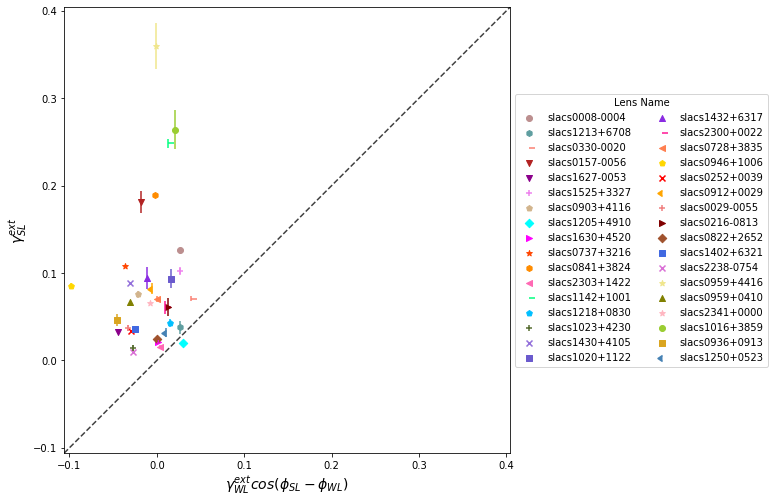

In [35]:
fig1, ax = plt.subplots(figsize=(10,10))
for weak_shear, info, instance, dataset, err in zip(gamma_combined_sie_sub, agg_shear_sie.values("info"), instances_shear, agg_shear_sie.values("dataset"), magnitudes[:, 1]):
    ax.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'], label=dataset.name)
    ax.errorbar(weak_shear, instance.galaxies.lens.shear.magnitude,
                    yerr=err,
                    color=info['colour'])
plt.xlabel(r'$\gamma_{WL}^{ext}cos(\phi_{SL}-\phi_{WL})$', size=14)
plt.ylabel(r'$\gamma_{SL}^{ext}$', size=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
     ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.savefig(f"{fig_path}shear_comparison_sie_sub.png", bbox_inches='tight', dpi=300)

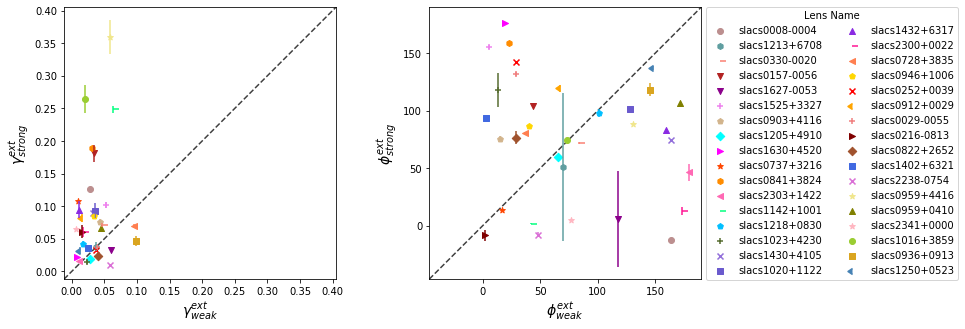

In [36]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
for weak_shear, weak_angle, info, instance, dataset, pa, err_p, err_m in \
        zip(average_shear,
            average_angle,
            agg_shear_sie.values("info"),
            instances_shear,
            agg_shear_sie.values("dataset"),
            pa_y_up,
            phis[:,1],
            magnitudes[:,1]):
    ax1.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'])
    ax1.errorbar(weak_shear, instance.galaxies.lens.shear.magnitude,
                    yerr=err_m,
                    color=info['colour'])
    ax2.scatter(weak_angle, pa,
              color=info['colour'], marker=info['marker'], label=dataset.name)
    ax2.errorbar(weak_angle, pa,
                    yerr=err_p,
                    color=info['colour'])
ax1.set_xlabel(r'$\gamma_{weak}^{ext}$', size=14)
ax1.set_ylabel(r'$\gamma_{strong}^{ext}$', size=14)
ax2.set_xlabel(r'$\phi_{weak}^{ext}$', size=14)
ax2.set_ylabel(r'$\phi_{strong}^{ext}$', size=14)
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width, box2.height])
box1 = ax1.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width, box1.height])
legend = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims1 = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
     ]
ax1.plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims1)
ax1.set_ylim(lims1)
lims2 = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
     ]
ax2.plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims2)
ax2.set_ylim(lims2)
plt.savefig(f"{fig_path}shear_and_angle_comparison.png", bbox_inches='tight', dpi=300)

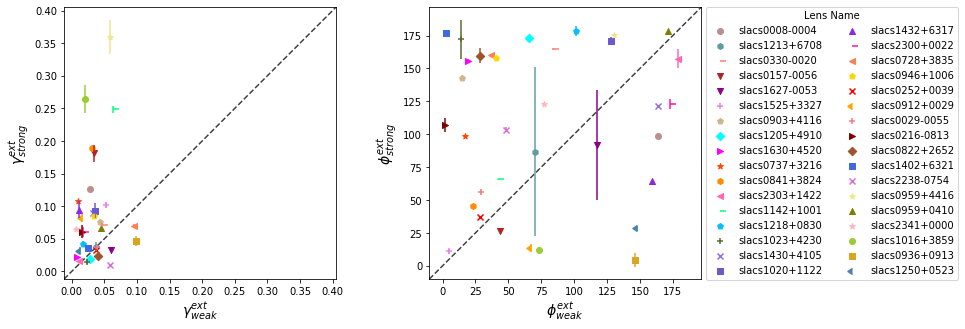

In [37]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
for weak_shear, weak_angle, info, instance, dataset, pa, err_p, err_m in \
        zip(average_shear,
            average_angle_north_up,
            agg_shear_sie.values("info"),
            instances_shear,
            agg_shear_sie.values("dataset"),
            pa_north_up,
            phis[:,1],
            magnitudes[:,1]):
    ax1.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'])
    ax1.errorbar(weak_shear, instance.galaxies.lens.shear.magnitude,
                    yerr=err_m,
                    color=info['colour'])
    ax2.scatter(weak_angle, pa,
              color=info['colour'], marker=info['marker'], label=dataset.name)
    ax2.errorbar(weak_angle, pa,
                    yerr=err_p,
                    color=info['colour'])
ax1.set_xlabel(r'$\gamma_{weak}^{ext}$', size=14)
ax1.set_ylabel(r'$\gamma_{strong}^{ext}$', size=14)
ax2.set_xlabel(r'$\phi_{weak}^{ext}$', size=14)
ax2.set_ylabel(r'$\phi_{strong}^{ext}$', size=14)
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width, box2.height])
box1 = ax1.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width, box1.height])
legend = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims1 = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
     ]
ax1.plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims1)
ax1.set_ylim(lims1)
lims2 = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
     ]
ax2.plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims2)
ax2.set_ylim(lims2)
plt.savefig(f"{fig_path}shear_and_angle_comparison_north_up.png", bbox_inches='tight', dpi=300)

In [40]:
average_sie_subtracted_angle = [pa+180 if pa<0 else pa for pa in average_sie_subtracted_angle]

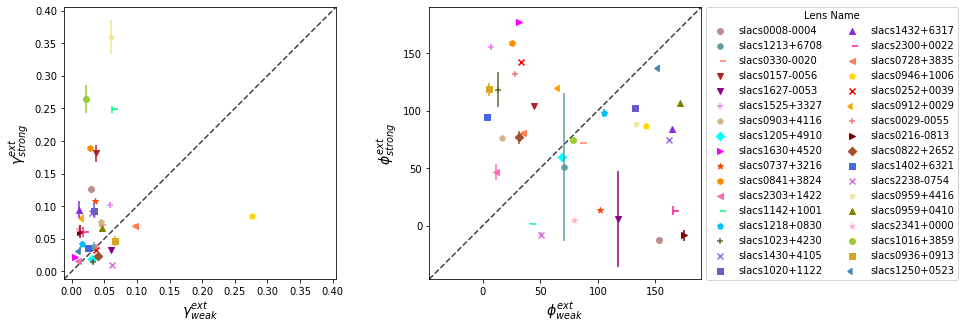

In [41]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
for weak_shear, weak_angle, info, instance, dataset, pa, err_p, err_m in \
        zip(average_sie_subtracted_shear,
            average_sie_subtracted_angle,
            agg_shear_sie.values("info"),
            instances_shear,
            agg_shear_sie.values("dataset"),
            pa_y_up,
            phis[:,1],
            magnitudes[:,1]):
    ax1.scatter(weak_shear, instance.galaxies.lens.shear.magnitude,
              color=info['colour'], marker=info['marker'])
    ax1.errorbar(weak_shear, instance.galaxies.lens.shear.magnitude,
                    yerr=err_m,
                    color=info['colour'])
    ax2.scatter(weak_angle, pa,
              color=info['colour'], marker=info['marker'], label=dataset.name)
    ax2.errorbar(weak_angle, pa,
                    yerr=err_p,
                    color=info['colour'])
ax1.set_xlabel(r'$\gamma_{weak}^{ext}$', size=14)
ax1.set_ylabel(r'$\gamma_{strong}^{ext}$', size=14)
ax2.set_xlabel(r'$\phi_{weak}^{ext}$', size=14)
ax2.set_ylabel(r'$\phi_{strong}^{ext}$', size=14)
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width, box2.height])
box1 = ax1.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width, box1.height])
legend = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims1 = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
     ]
ax1.plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims1)
ax1.set_ylim(lims1)
lims2 = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
     ]
ax2.plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims2)
ax2.set_ylim(lims2)
plt.savefig(f"{fig_path}shear_and_angle_comparison_sie_sub.png", bbox_inches='tight', dpi=300)

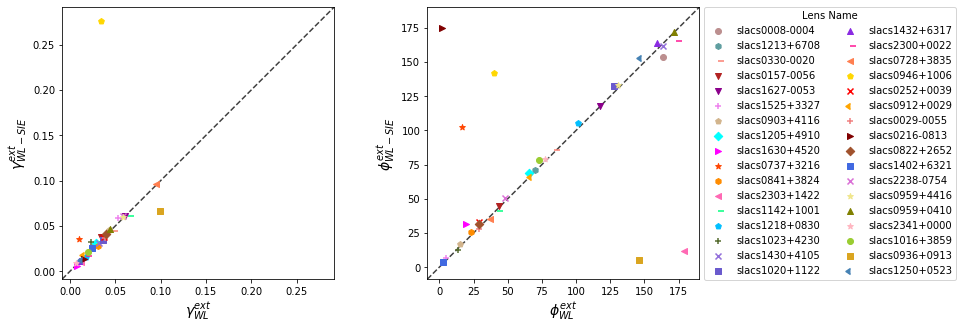

In [42]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
for weak_shear_sub, weak_angle_sub, info, weak_shear, weak_angle, dataset in \
        zip(average_sie_subtracted_shear,
            average_sie_subtracted_angle,
            agg_shear_sie.values("info"),
            average_shear,
            average_angle,
            agg_shear_sie.values("dataset")):
    ax1.scatter(weak_shear, weak_shear_sub,
              color=info['colour'], marker=info['marker'])
    ax2.scatter(weak_angle, weak_angle_sub,
              color=info['colour'], marker=info['marker'], label=dataset.name)
ax1.set_xlabel(r'$\gamma_{WL}^{ext}$', size=14)
ax1.set_ylabel(r'$\gamma_{WL-SIE}^{ext}$', size=14)
ax2.set_xlabel(r'$\phi_{WL}^{ext}$', size=14)
ax2.set_ylabel(r'$\phi_{WL-SIE}^{ext}$', size=14)
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width, box2.height])
box1 = ax1.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width, box1.height])
legend = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= 'Lens Name', ncol=2)
lims1 = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
     ]
ax1.plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
ax1.set_aspect('equal')
ax1.set_xlim(lims1)
ax1.set_ylim(lims1)
lims2 = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
     ]
ax2.plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
ax2.set_aspect('equal')
ax2.set_xlim(lims2)
ax2.set_ylim(lims2)
plt.savefig(f"{fig_path}shear_and_angle_comparison_with_and_without_subtracted_sie_shear.png", bbox_inches='tight', dpi=300)
